In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from BinanceCollector import BinanceCollector
from TradeBook import TradeBook
import warnings
warnings.filterwarnings("ignore")
from BreakdownCalculator import BreakdownCalculator
from BinanceSync import BinanceSync
from sklearn.model_selection import train_test_split
from tensorflow import keras
from HyperBacktest import HyperBacktest

c:\Users\deves\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
collector = BinanceCollector("ETHUSDT","2022-01-01","2023-01-02","15m")
collector.start_collect()
collector.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
df = collector.df
breakdown = BinanceCollector("ETHUSDT","2022-01-01","2023-01-02","1m")
breakdown.start_collect()
breakdown.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
breakdown_df = breakdown.df
calculator = BreakdownCalculator(breakdown_df)

In [3]:
df["Open Time"] = pd.to_datetime(df["Open Time"],unit="ms")
df["Close Time"] = pd.to_datetime(df["Close Time"]+1,unit="ms")
open_time = df["Open Time"]

In [4]:
df["EMA_20"] = df["Close"].ewm(span=20,adjust=False).mean()
df["EMA_50"] = df["Close"].ewm(span=50,adjust=False).mean()
df["EMA_200"] = df["Close"].ewm(span=200,adjust=False).mean()

df = df[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200","Open Time"]]

# Normalising Data
# df = (df - df.mean())/df.std()

In [5]:
# Filter dataframe for month
df = df[df["Open Time"].dt.month == 4]
df.reset_index(inplace=True)

In [6]:
df["Buy"] = np.where( (df["EMA_20"] > df["EMA_50"]) & (df["EMA_20"].shift(1) <= df["EMA_50"].shift(1) ),1,0 )
df["Sell"] = np.where( (df["EMA_20"] < df["EMA_50"]) & (df["EMA_20"].shift(1) >= df["EMA_50"].shift(1) ),1,0 )
df["Returns"] = 0

In [8]:
main = df.copy()
main.tail()

,index,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns
2845,11395,2794.99,2795.00,2780.00,2781.21,2793.757795,2802.798689,2837.919246,2022-04-30 22:45:00,0,0,0
2846,11396,2781.22,2785.82,2709.26,2739.86,2788.624672,2800.330505,2836.943532,2022-04-30 23:00:00,0,0,0
2847,11397,2739.86,2744.56,2728.56,2735.48,2783.563274,2797.787348,2835.933945,2022-04-30 23:15:00,0,0,0
2848,11398,2735.49,2749.99,2722.10,2725.37,2778.021058,2794.947452,2834.833806,2022-04-30 23:30:00,0,0,0
2849,11399,2725.37,2737.55,2720.34,2726.66,2773.129528,2792.269513,2833.757450,2022-04-30 23:45:00,0,0,0


In [9]:
max_time = 1*(24*60/15) # Days*C

target = 4/100
sl = -2/100
wins = 0
losses = 0
# For each buy signal
for i in np.where( (df["Buy"] == 1) )[0]:
    # df["Returns"][i] = 0
    # continue
    target_price = df["Close"][i] * (1+target)
    sl_price = df["Close"][i] * (1+sl)
    from_time = df["Open Time"][i]
    to_time = min(df["Open Time"][i] + pd.Timedelta(minutes=15*max_time),df["Open Time"][len(df) - 1])
    df["Returns"][i] = calculator.calculate(from_time,to_time,target_price,sl_price) - 0.1 # Fees
    if df["Returns"][i] > 0:
        wins += 1
    else:
        losses += 1

target = -4/100
sl = 2/100
wins = 0
losses = 0
# For each sell signal
for i in np.where( (df["Sell"] == 1) )[0]:
    # df["Returns"][i] = 0
    # continue
    target_price = df["Close"][i] * (1+target)
    sl_price = df["Close"][i] * (1+sl)
    from_time = df["Open Time"][i]
    to_time = min(df["Open Time"][i] + pd.Timedelta(minutes=15*max_time),df["Open Time"][len(df) - 1])
    df["Returns"][i] = calculator.calculate(from_time,to_time,target_price,sl_price,trade="short") - 0.1 # Fees
    if df["Returns"][i] > 0:
        wins += 1
    else:
        losses += 1

In [16]:
df = main.copy()
backtest = HyperBacktest(4,-2,calculator,df,short=False)
backtest.run()
df = backtest.df

<AxesSubplot:>

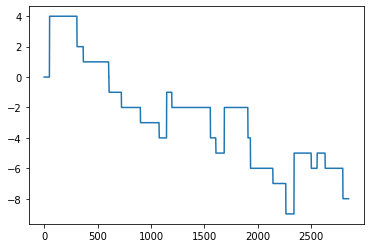

In [17]:
df["Returns"].cumsum().plot()
# df["Returns"].sum()

In [42]:
df[ (df["Buy"] == 1) & (df["Returns"] < 0) ]

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Buy,Sell,Returns,Open Time
408,3820.98,3821.51,3812.73,3817.82,3811.501825,3811.299024,3795.657448,1,0,-2,2022-01-05 07:15:00
444,3809.73,3820.39,3805.99,3819.76,3811.111326,3810.799817,3800.374246,1,0,-1,2022-01-05 16:15:00
553,3449.15,3455.83,3446.58,3447.29,3423.356897,3422.505477,3573.222997,1,0,-2,2022-01-06 19:45:00
670,3228.13,3229.64,3219.08,3225.51,3209.704034,3209.394007,3339.281774,1,0,-2,2022-01-08 01:30:00
683,3221.87,3227.46,3217.97,3218.69,3209.102046,3208.866012,3323.252767,1,0,-2,2022-01-08 04:45:00
...,...,...,...,...,...,...,...,...,...,...,...
33184,1277.12,1278.26,1275.79,1278.12,1271.967696,1271.966379,1285.226014,1,0,-2,2022-12-16 07:30:00
33425,1184.16,1186.30,1183.58,1183.95,1180.735682,1180.661149,1191.986788,1,0,-1,2022-12-18 20:15:00
33480,1184.81,1188.38,1184.80,1187.00,1183.228258,1182.998361,1188.551673,1,0,-1,2022-12-19 10:15:00
33727,1213.82,1217.67,1213.81,1217.64,1212.371901,1212.060848,1207.399937,1,0,-1,2022-12-22 00:45:00


In [71]:
# Optimizing data for profitable buy signals
x = df[ df["Buy"] == 1 ]
y = np.where( x["Returns"] > 2,1 ,0 )
x = x[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200"]]

In [72]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x_train = np.reshape( np.array(x_train), (x_train.shape[0],1,x_train.shape[1]) )
x_test = np.reshape( np.array(x_test), (x_test.shape[0],1,x_test.shape[1]) )

In [130]:
model = keras.Sequential([
    keras.layers.GRU(12,return_sequences=True,input_shape=(1,7)),
    keras.layers.Dense(8,activation="relu"),
    keras.layers.Dense(4,activation="tanh"),
    keras.layers.Dense(2),
    keras.layers.Softmax()
])

# keras.losses.c

model.compile(optimizer="ftrl",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train,epochs=10)

Train on 260 samples
Epoch 1/10
260/260 [==============================] - 2s 6ms/sample - loss: 0.7050 - acc: 0.7188
Epoch 2/10
260/260 [==============================] - 0s 200us/sample - loss: 0.6902 - acc: 0.8046
Epoch 3/10
260/260 [==============================] - 0s 169us/sample - loss: 0.6890 - acc: 0.8046
Epoch 4/10
260/260 [==============================] - 0s 169us/sample - loss: 0.6879 - acc: 0.8012
Epoch 5/10
260/260 [==============================] - 0s 192us/sample - loss: 0.6870 - acc: 0.8012
Epoch 6/10
260/260 [==============================] - 0s 181us/sample - loss: 0.6861 - acc: 0.8012
Epoch 7/10
260/260 [==============================] - 0s 181us/sample - loss: 0.6854 - acc: 0.8080
Epoch 8/10
260/260 [==============================] - 0s 173us/sample - loss: 0.6848 - acc: 0.8012
Epoch 9/10
260/260 [==============================] - 0s 154us/sample - loss: 0.6841 - acc: 0.8080
Epoch 10/10
260/260 [==============================] - 0s 165us/sample - loss: 0.6836 - ac

In [131]:
model.evaluate(x_test,y_test)

65/65 [==============================] - 1s 23ms/sample - loss: 0.6849 - acc: 0.7653


[0.684859459216778, 0.76525134]

In [138]:
tmp = x_train[3]
tmp_r = y_train[3]
tmp = np.reshape(tmp,(1,1,7))

In [139]:
model.predict(tmp)

array([[[0.50829697, 0.491703  ]]], dtype=float32)